# Multiple Domain Testing

## Mash Tests

In [15]:
import test_manifold_algorithms as tma
from MASH_MD import MASH
import matplotlib.pyplot as plt
import numpy as np

In [16]:
dc0a = tma.test_manifold_algorithms("iris.csv", split = "distort", percent_of_anchors= [0.05], verbose = 5, random_state=42)
dc0b = tma.test_manifold_algorithms("iris.csv", split = "distort", percent_of_anchors= [0.05], verbose = 5, random_state=42)


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [17]:
md = MASH(t = -1, knn = 5, distance_measures= ["default", "euclidean", "default"], verbose = 5)

In [18]:
#Testing fit portions
md.domains = [dc0a.split_A, dc0a.split_B, dc0b.split_B]
md.domain_count = len(md.domains)
md.build_graphs()

 Time it took to execute the graph for domain 0:  0.08472
 Time it took to compute kernal 0:  0.0003
 Time it took to execute SGDM for domain 1:  0.0004
 Time it took to execute the graph for domain 1:  0.06954
 Time it took to execute the graph for domain 2:  0.06931
 Time it took to compute kernal 2:  0.0001


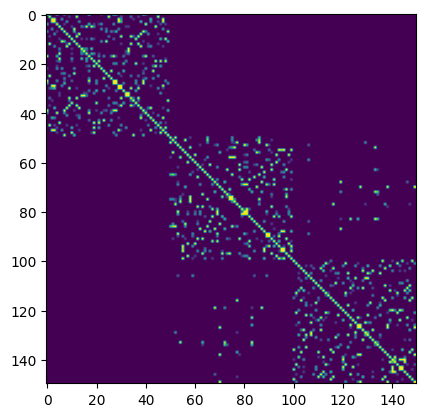

In [19]:
plt.imshow(md.kernals[0])

In [20]:
dc0b.anchors[:, 0]

array([ 28,   6,  70,  62,  57,  35,  26, 139,  22, 108,   8,   7,  23,
        55,  59, 129, 148,  50, 107,  56, 114,  71,   1,  97, 103,  20,
        89,  54,  43, 144,  19,  27, 126, 121,  13,  11,  48,  12,  45,
       140,  44,  77,  33, 125,   5,  93,  58,  68,  15, 113,  10, 147,
        37,  80,  79,  46,  73,  24,  90, 142, 105,  84,  29, 117,  99,
        87, 112, 100, 120, 106,  94, 124,  47, 111, 143,  34,   9,  21,
       102,  31,  78, 135,  82,  74, 149,  41, 138,  14,  52,   2,  51,
        69,  25,  17,   4, 115,  36,  76,  96, 122,  64,  98, 145,  49,
        88, 104,  16,  91, 101,  81,  66, 116,  86, 118, 110, 137, 146,
        42,  67,  60,  92, 127,  53,   3, 136, 128, 123,  72, 132, 119,
        30,  83,  18, 131,  32,  95, 141,   0,  85,  65,  38,  40,  39,
       130,  61,  75, 134, 109, 133,  63])

In [21]:
md.known_anchors = np.column_stack([dc0a.anchors[:50], dc0b.anchors[:50, 0]])
md.known_anchors[:4]

array([[28, 28, 28],
       [ 6,  6,  6],
       [70, 70, 70],
       [62, 62, 62]])

In [22]:
#Cache the lengths of the domains
md.len_domains = [len(domain) for domain in md.domains]
for length in md.len_domains:
    print(length)

150
150
150


In [23]:
md.known_anchors_adjusted = np.array(md.known_anchors)
for i, length in enumerate(md.len_domains):
    if i == len(md.domains) - 1:
        break
    else:
        md.known_anchors_adjusted += np.concatenate((np.repeat(0, i+1), np.repeat(length, len(md.domains)-(i+1))))
md.known_anchors_adjusted[:4], md.known_anchors[:4]

(array([[ 28, 178, 328],
        [  6, 156, 306],
        [ 70, 220, 370],
        [ 62, 212, 362]]),
 array([[28, 28, 28],
        [ 6,  6,  6],
        [70, 70, 70],
        [62, 62, 62]]))

In [24]:
md.graphAB = md.merge_graphs()

ValueError: unsupported data types in input

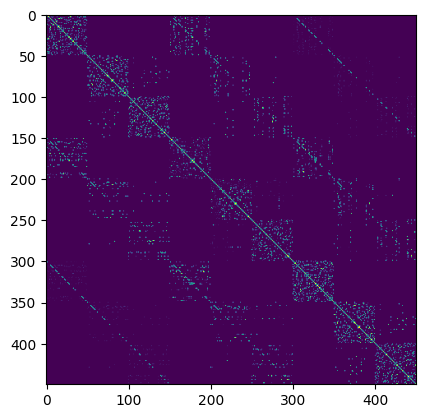

In [ ]:
plt.imshow(md.graphAB)

In [ ]:
md.fit([dc0a.split_A, dc0a.split_B, dc0b.split_A], md.known_anchors)

Time Data Below
 Time it took to execute the graph for domain 0:  0.07919
 Time it took to compute kernal 0:  9e-05
 Time it took to execute SGDM for domain 1:  0.00035
 Time it took to execute the graph for domain 1:  0.07327
 Time it took to execute the graph for domain 2:  0.07418
 Time it took to compute kernal 2:  0.00038
 Time it took to compute merge_graphs function:  0.08872
 Time it took to compute similarity_matrix function:  0.00094
Using optimal t value of 30
 Time it took to compute diffusion process:  5.2217
Fit process finished. We recommend calling optimize_by_creating_connections.


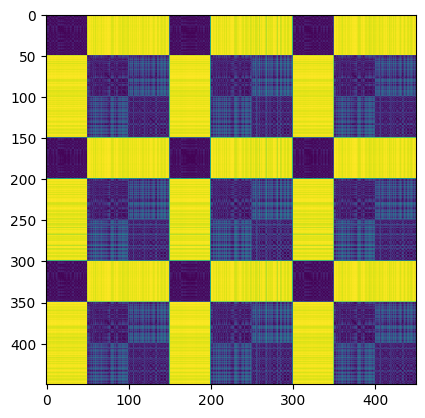

In [ ]:
plt.imshow(md.int_diff_dist)

<Axes: >

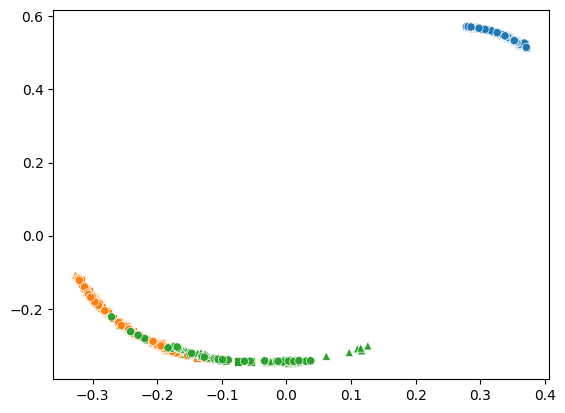

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS



mds = MDS(metric=True, dissimilarity = 'precomputed', random_state = 42, n_components=2)
labels_tripled = np.concatenate((dc0a.labels_doubled, dc0b.labels))
emb1 = mds.fit_transform(md.int_diff_dist)
styles = ['Graph1' if i < len(emb1[:]) / 3 else 'Graph2' if i < len(emb1[:]) * (2 / 3) else "Graph3" for i in range(len(emb1[:]))]

sns.scatterplot(legend = False, x = emb1[:, 0], y = emb1[:, 1], hue = pd.Categorical(labels_tripled), style = styles, markers = {"Graph1": 's', "Graph2": "^", "Graph3": "o"})